In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# from matplotlib import style
import seaborn as sns
%matplotlib inline

from env import get_db_url

# Acquire

In [5]:
url = get_db_url('curriculum_logs')
query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip
FROM logs;
'''
df = pd.read_sql(query, url)
print(df.shape)
df.head()

(900223, 5)


,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


# Prepare

In [6]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['endpoint'].resample('d').count()
pages.head()


date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<Axes: xlabel='date'>

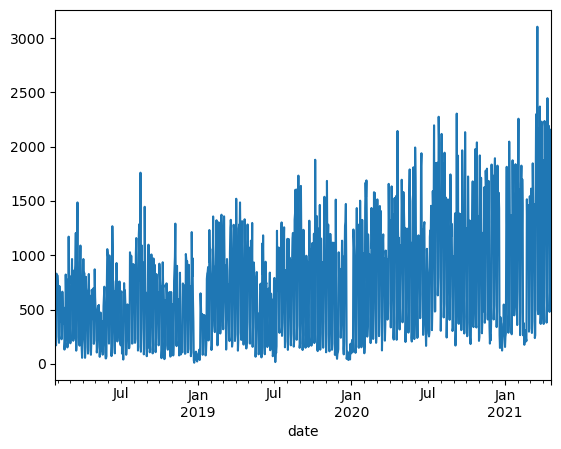

In [7]:
pages.plot()


# Exponential Moving Average

In [8]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()


date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

In [9]:
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()


date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: endpoint, dtype: float64

In [10]:
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()


date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [11]:
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()


date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: endpoint, dtype: float64

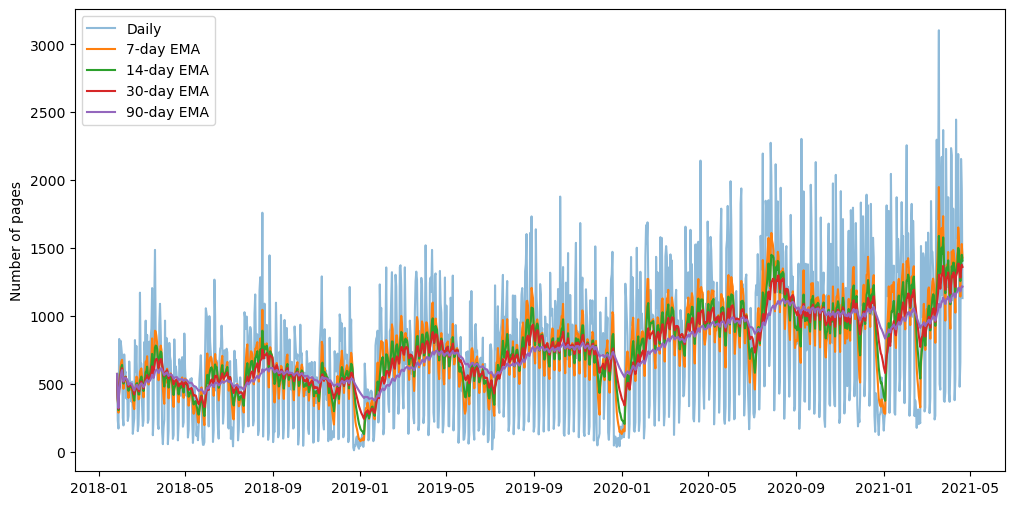

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


# Bollinger Bands and %b


In [14]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()


date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [15]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()


date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [16]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub


date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
                 ...     
2021-04-17    3545.216722
2021-04-18    3486.733695
2021-04-19    3569.147958
2021-04-20    3579.231798
2021-04-21    3499.094360
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [17]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()


,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [18]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()


,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


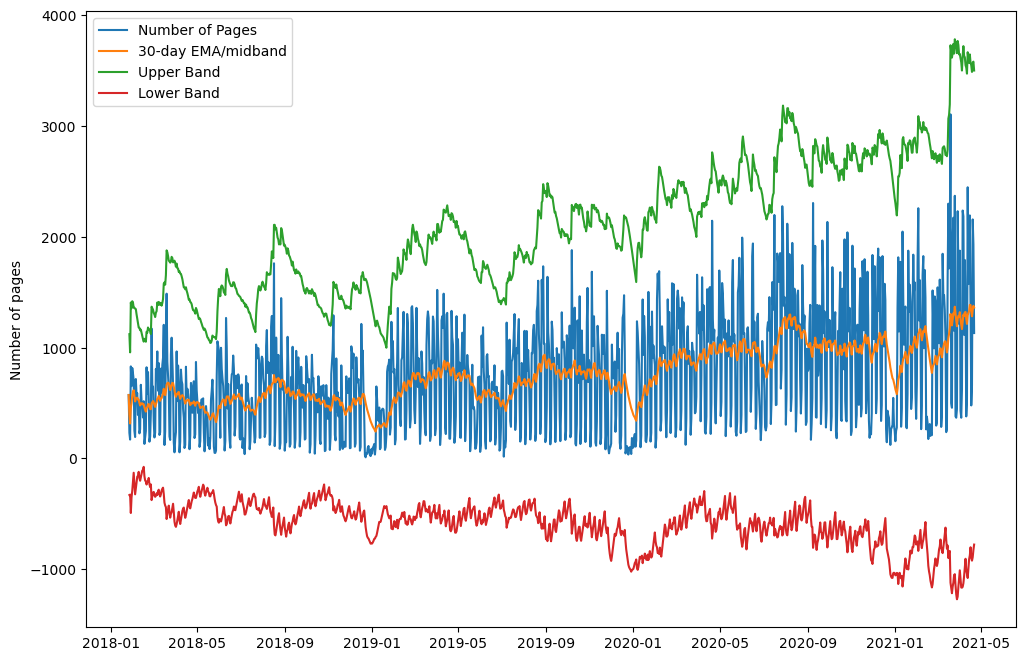

In [19]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


# Compute %b

In [21]:
# get the last measure of gb
last_measure = my_df.iloc[-1].pages
last_measure


1131.0

In [22]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb


-777.3404511353885

In [24]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub

3499.0943598250406

In [25]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))


%b for last datapoint:  0.45


In [26]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()


,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


In [27]:
my_df[my_df['pct_b']>1]


,pages,midband,ub,lb,pct_b
date,,,,,


In [28]:
# def acquire(file_name, column_names):
#     return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]


In [34]:
user = 1
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)


In [35]:
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,


In [36]:
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [37]:
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3
...,...,...,...,...,...,...
2021-01-24,7,0.574393,6.857226,-5.708440,1.011362,817
2021-03-25,59,6.824556,58.415342,-44.766230,1.005666,843
2021-02-23,67,8.229409,66.322904,-49.864086,1.005828,851


In [38]:
anomalies.sort_values(by='pct_b', ascending=False)

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2020-12-24,1,0.064516,0.939061,-0.810028,1.034841,232
2020-12-16,12,0.774194,11.268729,-9.720342,1.034841,156
2020-09-13,4,0.258065,3.756243,-3.240114,1.034841,210
2020-05-12,16,1.032258,15.024972,-12.960456,1.034841,93
2019-09-12,16,1.032258,15.024972,-12.960456,1.034841,94
...,...,...,...,...,...,...
2021-03-23,146,26.440411,145.913292,-93.032470,1.000363,581
2020-09-17,24,2.103030,23.984360,-19.778300,1.000357,560
2020-10-27,17,1.232625,16.991469,-14.526220,1.000271,613


In [40]:
anomalies.sort_values(by='pages', ascending=False)

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2018-06-02,198,16.484863,188.766965,-155.797239,1.026796,138
2019-12-19,192,19.601776,187.231096,-148.027544,1.014225,526
2020-10-16,179,20.158062,173.720239,-133.404115,1.017191,658
2020-06-05,165,20.035882,163.037501,-122.965736,1.006862,521
...,...,...,...,...,...,...
2019-05-21,1,0.064519,0.939144,-0.810106,1.034790,19
2020-11-21,1,0.065202,0.959398,-0.828994,1.022703,410
2019-03-20,1,0.064516,0.939061,-0.810029,1.034841,126


# Exercises

file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb
The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

Hint: You will need to explore the database (yay SQL!)

# 1. Label students by the program they are in.

In [42]:
url = get_db_url('curriculum_logs')
query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip,
       c.program_id
FROM logs
JOIN cohorts as c ON c.id=user_id;
'''
df = pd.read_sql(query, url)
print(df.shape)
df.head()

(73739, 6)


,date,endpoint,user_id,cohort_id,source_ip,program_id
0,2018-01-26,/,1,8.0,97.105.19.61,1
1,2018-01-26,java-ii,1,8.0,97.105.19.61,1
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,1
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,1
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,1


In [48]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

# 2. Is it possible to identify the user_id of a staff member?

In [49]:
df.program_id.value_counts()

1    37794
2    31980
3     2458
4     1507
Name: program_id, dtype: int64

In [50]:
df.cohort_id.value_counts()

28.0    25097
22.0    23840
14.0     8401
23.0     5612
21.0     3413
1.0      3252
8.0      1617
13.0      592
18.0      474
16.0      107
Name: cohort_id, dtype: int64

# 3. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [76]:
url = get_db_url('curriculum_logs')
query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip,
       c.program_id,
       c.end_date
FROM logs
JOIN cohorts as c ON c.id=user_id
WHERE end_date < date;
'''
df1 = pd.read_sql(query, url)
print(df.shape)
df1.head()



(46616, 7)


,date,endpoint,user_id,cohort_id,source_ip,program_id,end_date
0,2018-01-26,/,1,8.0,97.105.19.61,1,2014-04-22
1,2018-01-26,java-ii,1,8.0,97.105.19.61,1,2014-04-22
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,1,2014-04-22
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,1,2014-04-22
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,1,2014-08-22


In [77]:
df1.date = pd.to_datetime(df1.date)
df1 = df1.set_index(df1.date)
# pages = df1['endpoint'].resample('d').count()
# pages.head()

In [78]:
df1.end_date = pd.to_datetime(df1.end_date)

In [79]:
pages = df1['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    361
2018-01-27    109
2018-01-28    108
2018-01-29    418
2018-01-30    293
Freq: D, Name: endpoint, dtype: int64

<Axes: xlabel='date'>

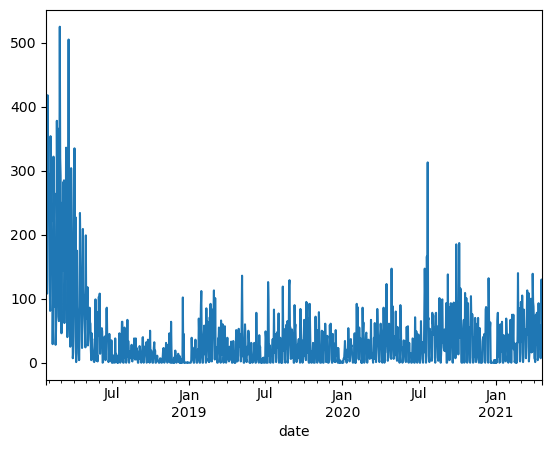

In [80]:
pages.plot()

In [58]:
url = get_db_url('curriculum_logs')
query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip,
       c.program_id,
       c.end_date
FROM logs
JOIN cohorts as c ON c.id=user_id
;
'''
df2 = pd.read_sql(query, url)
print(df.shape)
df2.head()


(46616, 7)


,date,endpoint,user_id,cohort_id,source_ip,program_id,end_date
0,2018-01-26,/,1,8.0,97.105.19.61,1,2014-04-22
1,2018-01-26,java-ii,1,8.0,97.105.19.61,1,2014-04-22
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,1,2014-04-22
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,1,2014-04-22
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,1,2014-08-22


# 4. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.

In [81]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()


date
2018-01-26    361.000000
2018-01-27    230.800000
2018-01-28    187.108478
2018-01-29    250.727506
2018-01-30    260.345522
Freq: D, Name: endpoint, dtype: float64

In [82]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()


date
2018-01-26           NaN
2018-01-27    178.190909
2018-01-28    143.314494
2018-01-29    165.670229
2018-01-30    142.399233
Freq: D, Name: endpoint, dtype: float64

In [83]:
# compute upper and lower bands
ub = midband + stdev*2
lb = midband - stdev*2
ub


date
2018-01-26           NaN
2018-01-27    587.181818
2018-01-28    473.737465
2018-01-29    582.067965
2018-01-30    545.143988
                 ...    
2021-04-17    114.183251
2021-04-18    111.409477
2021-04-19    127.817437
2021-04-20    127.098812
2021-04-21    124.009245
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [84]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()


,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,587.181818,-125.581818
2018-01-28,473.737465,-99.520509
2018-01-29,582.067965,-80.612952
2018-01-30,545.143988,-24.452944


In [85]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()


,pages,midband,ub,lb
date,,,,
2018-01-26,361,361.000000,NaN,NaN
2018-01-27,109,230.800000,587.181818,-125.581818
2018-01-28,108,187.108478,473.737465,-99.520509
2018-01-29,418,250.727506,582.067965,-80.612952
2018-01-30,293,260.345522,545.143988,-24.452944


# 5. Plot the access activity of these students.

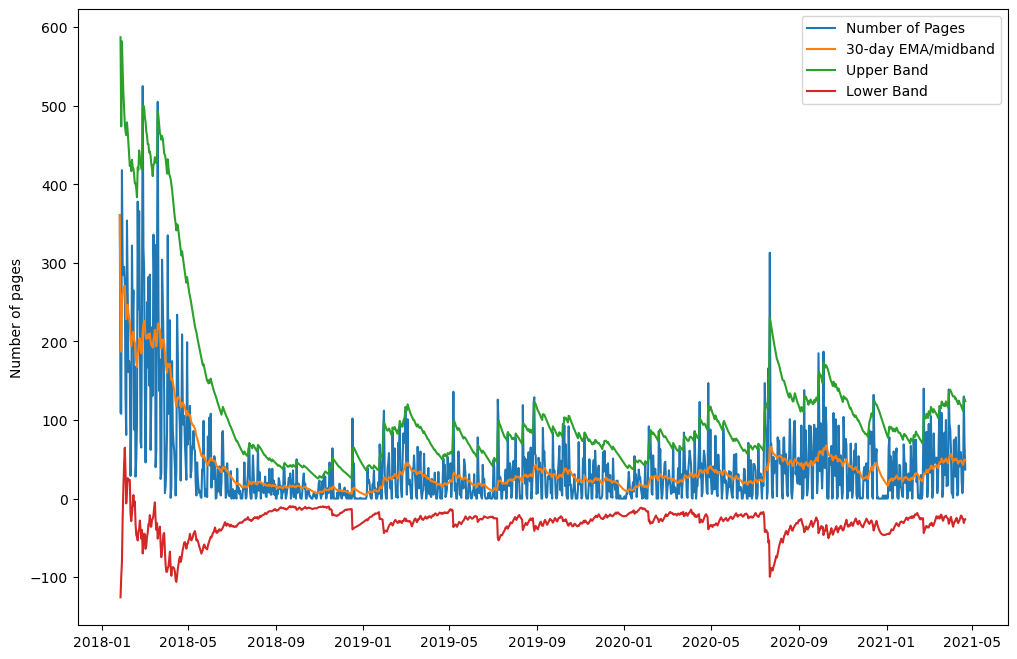

In [87]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


# BONUS: Can you identify users who are viewing both the web dev and data science cu